In [61]:
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
import time
import scipy.optimize as optimize
import math

In [2]:
# read movement data
with open("data/movements/a=3 b=1 p=0.025 gam=1.5/sample_movements.pkl", "rb") as file:
    movements = pkl.load(file)
print(movements.shape)
# get weather
with open("data/weather_crawl_all.pkl", "rb") as file:
    weather = pkl.load(file)
    
# conver weather into dictionary form
w_data = {}
for tp_loc in weather:
    tp_w = {}
    for tp_ym in weather[tp_loc]:
        for tp_data in weather[tp_loc][tp_ym]:
            tp_dt = tp_data['ds'].replace("年",",").replace("月",",").replace("日",",").split(",")
            tp_t = int(tp_data['ts'][:-1])
            tp_key = (int(tp_dt[0]), int(tp_dt[1]), int(tp_dt[2]), tp_t)
            tp_w[tp_key] = tp_data
    w_data[tp_loc] = tp_w
    
# read data
with open("data/boundary.pkl", "rb") as file:
    dis_bd = pkl.load(file)

locs = []
for tp_dis in dis_bd:
    locs.append(tp_dis)

(5000000, 184)


In [3]:
temperature_M = np.zeros((len(locs), movements.shape[1]-37))-1
humidity_M = np.zeros((len(locs), movements.shape[1]-37))-1
yms = [(2021,9), (2021,10), (2021,11), (2021,12), (2022,1)] # year and month
month_days = {(2021,9):(7,30), (2021,10):(1,31), 
              (2021,11):(1,30), (2021,12):(1,31), (2022,1):(1,31)} # numebr of days in each month
time_ex = [0, 6, 12, 18]
for i in range(len(locs)):
    tp_loc = locs[i]
    tp_dict = weather[tp_loc]
    tp_ct = 0 # count for the index of temperature/humidity matrix
    for tp_ym in yms:
        for tp_d in range(month_days[tp_ym][0], month_days[tp_ym][1]+1):
            tp_temp = 0
            tp_hum = 0
            for tp_t in time_ex:
                tp_key = (tp_ym[0], tp_ym[1], tp_d, tp_t)
                if w_data[tp_loc][tp_key]["desc"] == "No weather data available":
                    tp_temp = -100000
                    tp_hum = -100000
                    break
                else:
                    tp_temp += w_data[tp_loc][tp_key]["temp"]
                    tp_hum += w_data[tp_loc][tp_key]["temp"]
            tp_temp /= 4
            tp_hum /= 4
            temperature_M[i][tp_ct] = tp_temp
            humidity_M[i][tp_ct] = tp_temp
            tp_ct += 1
            
# interpolate temperature and humidity
for i in range(temperature_M.shape[1]):
    temp_index = (temperature_M[:, i]<-300)
    hum_index = (humidity_M[:, i]<-300)
    temperature_M[temp_index, i] = temperature_M[(temp_index==False),i].mean()
    humidity_M[hum_index, i] = humidity_M[(hum_index==False),i].mean()

In [4]:
print((temperature_M<0).sum())
print((humidity_M<0).sum())

0
0


In [5]:
# read estimated infections
with open("data/estimated_infection_bdis_bday.pkl", "rb") as file:
    infections = pkl.load(file)
    
# process infections into matrix
# the average for one week on 9/7
tp_time_tx = "2021/9/"
inf_dates = [tp_time_tx+str(i) for i in range(4,11)]
initial_infections = np.array([sum([infections[tp_loc][tp_dt] for tp_dt in inf_dates])/len(inf_dates) for tp_loc in locs])

In [6]:
initial_infections

array([ 1.08468874,  1.08468874,  6.92564678,  9.76219868,  3.02223913,
        1.05775326,  1.86815283,  1.41070427,  0.        ,  2.32794433,
        2.90672893,  0.49083945,  4.45900688,  5.65682713,  8.33129362,
        3.41532325,  6.50813245, 14.58196266, 10.4030451 ,  5.82897346,
        9.16446978,  3.70982132,  5.42344371,  5.599281  ,  3.2303465 ,
        2.31106945,  2.39451747,  2.16937748,  1.73779545,  1.00383134,
        3.74345135,  2.23362693,  0.        ,  4.85699402,  5.94319081,
        3.15603954,  3.40585209,  1.75398229,  0.10707512,  4.35455356,
        3.00476033,  2.61190242,  5.10589403,  2.41088357,  0.70647188,
        1.99893869,  2.85674476,  1.65506381,  4.71328552,  8.02237772,
       13.78351937,  7.55552546, 23.86315233,  5.21337124, 21.69377484])

In [7]:
pts = [[10.54,0.07585], [10.76,0.09169], [15.3, 0.03608], [16.52, 0.03266], [20.05, 0.04216], [21.79, 0.03718], [25.64, 0.03043],
      [27.64, 0.02709], [31.33, 0.04391], [31.65, 0.03417], [32.55, 0.04438], [33.41, 0.04983]]
real = np.array(pts)
x = real[:, 0]
y = real[:, 1]
def base_func(x, b0, b1, b2, b3, b4):
    y = b0 + b1*x + b2*x**2 + b3*x**3 + b4*x**4
    return y

cf = optimize.curve_fit(f=base_func, xdata=x, ydata=y, p0=[1,1,1,1,1])

In [8]:
cf[0]

array([ 8.59455846e-01, -1.53928039e-01,  1.05994167e-02, -3.18278157e-04,
        3.51061475e-06])

In [122]:
# defined the functions for time-varying variables
trans_r_human_to_vector = lambda T: 0.131-0.05723*T+0.01164*T**2-0.001341*T**3+0.00008723*T**4 - 0.000003017*T**5 + 5.153*10**(-8)*T**6 - 3.42*10**(-10)*T**7
mortality_r_vector_aqua = lambda T: 2.13 - 0.3797*T + 0.02457*T**2 - 0.0006778*T**3 + 0.000006794*T**4
mortality_r_vector_adul = lambda T: 0.8692 - 0.1599*T + 0.01116*T**2 - 0.0003408*T**3 + 0.000003809*T**4
mortality_r_vector_adul_2=lambda T: 0.8595 - 0.1539*T + 0.01060*T**2 - 0.0003183*T**3 + 0.000003511*T**4
oviposition_r_vector = lambda T: -5.4 + 1.8*T - 0.2124*T**2 + 0.01015*T**3 - 0.0001515*T**4
def incubation_vector(T):
    K = T+273.15
    R = 1.987
    inc = 0.003359*K/298*np.exp((15000/R*(1/298-
                                          1/K)))/(1+np.exp(6.203*10**21/R*
                                                           (1/(-2.176*10**30)-1/K)))
    return inc*24

infection_hu_to_vec = lambda T: 0.001044*T*(T-12.286)*(32.461-T)**0.5 # this can be negative!
infection_vec_to_hu = lambda T: 0.0729*T - 0.97 # this is a bit weird

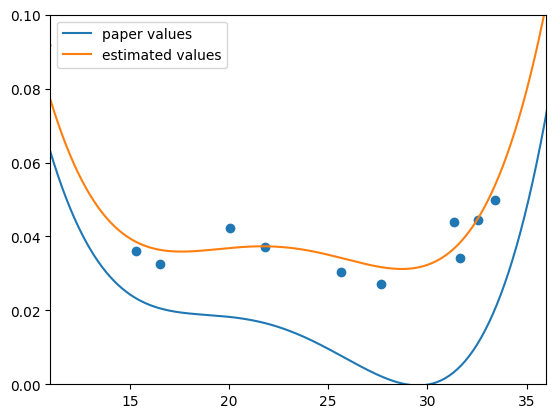

In [130]:
tp_Ts = [i/10 for i in range(100,400)]
plt.plot(tp_Ts, [mortality_r_vector_adul(T) for T in tp_Ts], label="paper values")
plt.plot(tp_Ts, [mortality_r_vector_adul_2(T) for T in tp_Ts], label="estimated values")
plt.scatter(real[:,0], real[:,1])
plt.xlim(11,36)
plt.legend()
plt.ylim(0,0.1)
plt.show()